In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import ceo
%matplotlib inline

# Parameters

In [2]:
D = 25.5
nPx = 501
r0 = 15e-2
L0 = 25

# Circular telescope OTF

## Analytic

In [3]:
def circularOTF(_rho_,_D_):
    red = np.asarray(_rho_/_D_)
    out = np.zeros(red.shape)
    idx = red<1
    redd = red[idx]
    out[idx] =  (2/np.pi)*( np.arccos(redd) - redd*np.sqrt(1-redd**2) )
    return out

In [4]:
circularOTF(0,1)

array(1.0)

## Numeric

In [5]:
u = np.linspace(-1,1,nPx)
x,y = np.meshgrid(u,u)
r = np.hypot(x,y)
P = r<1

In [6]:
from scipy.signal import fftconvolve, correlate
AP = fftconvolve(P,P)/np.sum(P*P)

In [7]:
AP.shape

(1001, 1001)

In [8]:
print AP[100,100] , np.sum(P)

3.70660662882e-16 196297


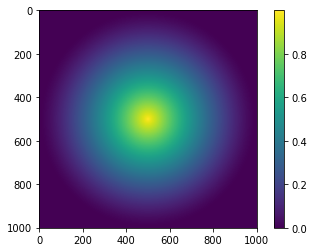

In [9]:
plt.imshow(AP)
plt.colorbar()

In [10]:
h = (AP.shape[0]-1)/2

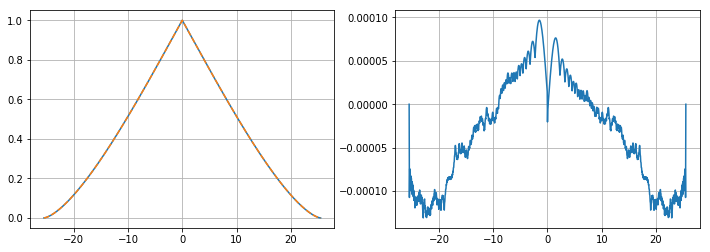

In [11]:
u = np.arange(2*nPx-1,dtype=np.float)*D/(nPx-1)
u = u-u[-1]/2

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,4)
ax1.plot(u,AP[:,h])
ax1.plot(u,circularOTF(np.abs(u),D),'--')
ax1.grid()
ax2.plot(u,AP[:,h] - circularOTF(np.abs(u),D))
ax2.grid()

In [13]:
src = ceo.Source('Vs',rays_box_sampling=nPx,rays_box_size=D,rays_origin=[0,0,25])
gmt = ceo.GMT_MX()
src>>(gmt,)
+src

r0  = 15e-2*(src.wavelength/0.5e-6)**1.2
print r0

OPTICAL PATH: ['GMT_MX']
0.149999999546


In [14]:
W = src.amplitude.host()*np.exp(1j*2.*np.pi*src.phase.host()/src.wavelength)

In [15]:
AW0 = fftconvolve(W,W)

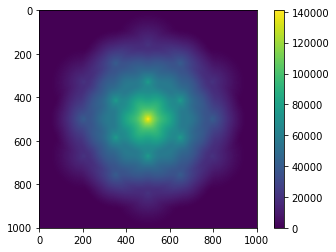

In [16]:
plt.imshow(np.real(AW0))
plt.colorbar()

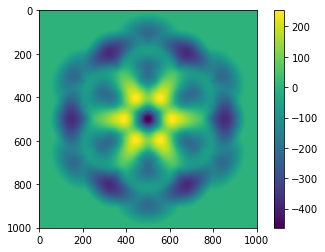

In [17]:
plt.imshow(np.imag(AW0))
plt.colorbar()

# Atmosphere OTF

In [18]:
from scipy.special import gamma, kv

## Atmosphere structure function

In [19]:
def atmSF(_rho_,_r0_,_L0_):
    c = 2*gamma(11./6.)*(24.*gamma(6./5.)/5.)**(5./6.)/(2**(5./6.)*np.pi**(8./3.))
    red = np.asarray(2*np.pi*_rho_/_L0_)
    out = np.zeros(red.shape)
    idx = red!=0
    redd = red[idx]
    out[idx] = c*(_L0_/_r0_)**(5./3.)*(gamma(5./6.)/2**(1./6.) - redd**(5./6.)*kv(5./6.,redd))
    return out

In [20]:
atmSF(0,r0,L0), atmSF(L0*10,r0,L0), 2*gamma(11./6.)*gamma(5./6.)*(L0/r0)**(5./3.)*(24.*gamma(6./5.)/5.)**(5./6.)/(2*np.pi**(8./3.))

(array(0.0), array(871.3530396182533), 871.35303961825343)

In [21]:
r0

0.1499999995455437

## Atmosphere OTF

In [22]:
def atmOTF(_rho_,_r0_,_L0_):
    return np.exp(-0.5*atmSF(_rho_,_r0_,_L0_))

In [23]:
atmOTF(0,r0,L0), atmOTF(L0*10,r0,L0)

(1.0, 6.1389140380060525e-190)

(-1, 1)

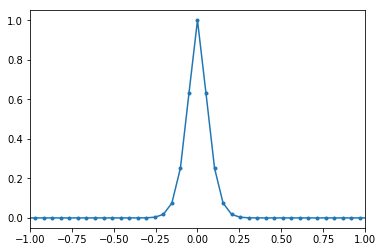

In [24]:
u = np.arange(2*nPx-1,dtype=np.float)*D/(nPx-1)
u = u-u[-1]/2
x,y = np.meshgrid(u,u)
rho = np.hypot(x,y)
C = atmOTF(rho,r0,L0)
plt.plot(u,C[nPx-1,:],'.-')
plt.xlim([-1,1])

In [25]:
r0_domeSeeing = 0.98*src.wavelength/(0.15*ceo.constants.ARCSEC2RAD)
r0wDomeSeeing = (r0_domeSeeing**(-5./3) + r0**(-5./3))**(-3./5)
print r0, r0_domeSeeing, r0wDomeSeeing

0.150000012568 0.741178255531 0.144051960486


(-1, 1)

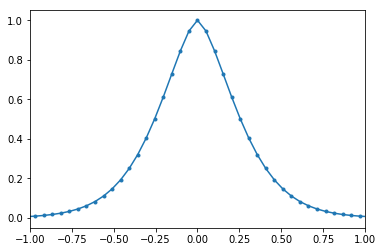

In [105]:
u = np.arange(2*nPx-1,dtype=np.float)*D/(nPx-1)
u = u-u[-1]/2
x,y = np.meshgrid(u,u)
rho = np.hypot(x,y)
CdomeSeeing = atmOTF(rho,r0wDomeSeeing,L0)
plt.plot(u,CdomeSeeing[nPx-1,:],'.-')
plt.xlim([-1,1])

In [23]:
u[0],u[-1]

(-25.5, 25.5)

# PSSN

In [24]:
np.sum(np.abs(AW0*C)**2)/np.sum(np.abs(AP*C/AP[100,100])**2)

2.6951037378084689e-21

In [25]:
def OTF(zen,azi):
    src.updateDirections(zen,azi)
    +src
    A = src.amplitude.host()
    F = src.phase.host()
    k = 2.*np.pi/src.wavelength
    W = A*np.exp(1j*k*F)  
    v = np.sum(A)
    #print v
    S1 = np.fliplr(np.flipud(W))
    S2 = np.conj(W)
    AW = fftconvolve(S1,S2)
    #print np.sum(W*np.conj(W))
    return AW#/v

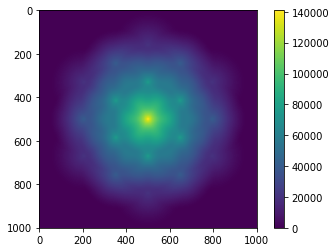

In [26]:
plt.imshow(np.abs(OTF(0,0)))
plt.colorbar()

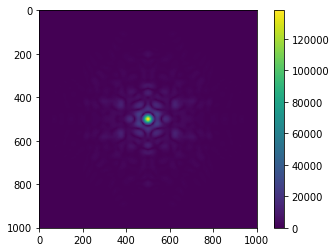

In [27]:
plt.imshow(np.abs(OTF(ceo.constants.ARCMIN2RAD*3,0)))
plt.colorbar()

In [28]:
def PSSn(zen,azi):
    AW0 = OTF(0,0)
    AW = OTF(zen,azi)
    return np.sum(np.abs(AW*C)**2)/np.sum(np.abs(AW0*C)**2)

In [29]:
def PSSnA(zen,azi,vignetting_only=False,wo_vignetting=False):
    k = 2.*np.pi/src.wavelength
    src.updateDirections(0,0)
    +src
    A0 = src.amplitude.host()
    F0 = src.phase.host()
    W0 = A0*np.exp(1j*k*F0)  
    S1 = np.fliplr(np.flipud(W0))
    S2 = np.conj(W0)
    AW0 = fftconvolve(S1,S2)
    src.updateDirections(zen,azi)
    +src
    A = src.amplitude.host()
    if vignetting_only:
        W = A
    else:
        F = src.phase.host()
        if wo_vignetting:
            W = A0*np.exp(1j*k*F)
        else:
            W = A*np.exp(1j*k*F)  
    v = np.sum(A)
    S1 = np.fliplr(np.flipud(W))
    S2 = np.conj(W)
    AW = fftconvolve(S1,S2)
    return np.sum(np.abs(AW*C)**2)/np.sum(np.abs(AW0*C)**2)

In [30]:
src.updateDirections(0,0)
pvar = np.zeros(500)
for k in range(500):
    gmt.M1.motion_CS.origin[:,2] = np.random.randn(7)*10e-6/2
    gmt.M1.motion_CS.update()
    +src
    #plt.imshow(src.phase.host(units='micron'))
    #plt.colorbar()
    pvar[k] = np.var(src.piston(where='segments'))

In [31]:
np.sqrt(np.mean(pvar))*1e6

9.0475220498117999

In [32]:
k = 2.*np.pi/src.wavelength
src.updateDirections(0,0)
+src
A0 = src.amplitude.host()
F0 = src.phase.host()
W0 = A0*np.exp(1j*k*F0)  
S1 = np.fliplr(np.flipud(W0))
S2 = np.conj(W0)
AW0 = fftconvolve(S1,S2)
Denom = np.sum(np.abs(AW0*C)**2)
def PSSnPiston(piston_rms):

    gmt.M1.motion_CS.origin[:,2] = np.random.randn(7)*piston_rms/2
    gmt.M1.motion_CS.update()
    +src
    A = src.amplitude.host()
    F = src.phase.host()
    W = A*np.exp(1j*k*F)  
    S1 = np.fliplr(np.flipud(W))
    S2 = np.conj(W)
    AW = fftconvolve(S1,S2)
    return np.sum(np.abs(AW*C)**2)/Denom

In [35]:
pssn = np.zeros(100)
for k in range(100):
    pssn[k] = PSSnPiston(10e-6)

1.00080834398


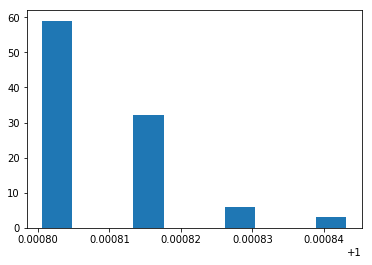

In [36]:
print np.mean(pssn)
plt.hist(pssn);

In [37]:
def PSSnDomeSeeing():
    k = 2.*np.pi/src.wavelength
    src.updateDirections(0,0)
    +src
    A0 = src.amplitude.host()
    F0 = src.phase.host()
    W0 = A0*np.exp(1j*k*F0)  
    S1 = np.fliplr(np.flipud(W0))
    S2 = np.conj(W0)
    AW0 = fftconvolve(S1,S2)
    return np.sum(np.abs(AW0*CdomeSeeing)**2)/np.sum(np.abs(AW0*C)**2)

In [38]:
src.wavelength

5.500000384017767e-07

In [39]:
PSSnDomeSeeing()

NameError: global name 'CdomeSeeing' is not defined

In [ ]:
PSSn(0,0), PSSn(10*ceo.constants.ARCMIN2RAD,0)

In [30]:
src = ceo.Source('Vs',rays_box_sampling=nPx,rays_box_size=D,rays_origin=[0,0,25])
gmt = ceo.GMT_MX()
src>>(gmt,)
+src

r0  = 15e-2*(src.wavelength/0.5e-6)**1.2
print r0
C = atmOTF(rho,r0,L0)

OPTICAL PATH: ['GMT_MX']
0.149999999546


In [31]:
print [PSSnA(x*ceo.constants.ARCMIN2RAD,0,vignetting_only=True) for x in [1.5,5,10]]
print [PSSnA(x*ceo.constants.ARCMIN2RAD,0,wo_vignetting=True) for x in [1.5,5,10]]

[0.98199309140025293, 0.92866189296147794, 0.85442351122217552]
[0.99367762949438221, 0.94422948413078867, 0.59589508018469972]


In [32]:
z = np.linspace(0,10,21)
l1_pssn_z = [PSSnA(x*ceo.constants.ARCMIN2RAD,0) for x in z]
l1_pssnp_z = [PSSnA(x*ceo.constants.ARCMIN2RAD,0,wo_vignetting=True) for x in z]
l1_pssnv_z = [PSSnA(x*ceo.constants.ARCMIN2RAD,0,vignetting_only=True) for x in z]

In [34]:
src = ceo.Source('H',rays_box_sampling=nPx,rays_box_size=D,rays_origin=[0,0,25])
gmt = ceo.GMT_MX()
src>>(gmt,)
+src

r0  = 15e-2*(src.wavelength/0.5e-6)**1.2
print r0
C = atmOTF(rho,r0,L0)

OPTICAL PATH: ['GMT_MX']
0.630332739781


In [38]:
print [PSSnA(x*ceo.constants.ARCMIN2RAD,0,vignetting_only=True) for x in [1.5,5,10]]
print [PSSnA(x*ceo.constants.ARCMIN2RAD,0,wo_vignetting=True) for x in [1.5,5,10]]

[0.98141142188085939, 0.92672765061938289, 0.85078503540664752]
[0.99755015227399002, 0.8646266007612432, 0.39468412582912532]


In [35]:
z = np.linspace(0,10,21)
l2_pssn_z = [PSSnA(x*ceo.constants.ARCMIN2RAD,0) for x in z]
l2_pssnp_z = [PSSnA(x*ceo.constants.ARCMIN2RAD,0,wo_vignetting=True) for x in z]
l2_pssnv_z = [PSSnA(x*ceo.constants.ARCMIN2RAD,0,vignetting_only=True) for x in z]

In [36]:
print l1_pssnp_z[-1], l1_pssnv_z[-1], l1_pssnp_z[-1]*l1_pssnv_z[-1], l1_pssn_z[-1]
print l2_pssnp_z[-1], l2_pssnv_z[-1], l2_pssnp_z[-1]*l2_pssnv_z[-1], l2_pssn_z[-1]

0.595895080185 0.854423511222 0.509146766731 0.498680566348
0.394684125829 0.850785035407 0.335791347968 0.341294183321


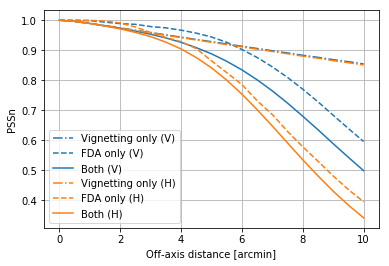

In [37]:
plt.plot(z,l1_pssnv_z,'C0-.',label='Vignetting only (V)')
plt.plot(z,l1_pssnp_z,'C0--',label='FDA only (V)')
plt.plot(z,l1_pssn_z,'C0',label='Both (V)')
plt.plot(z,l2_pssnv_z,'C1-.',label='Vignetting only (H)')
plt.plot(z,l2_pssnp_z,'C1--',label='FDA only (H)')
plt.plot(z,l2_pssn_z,'C1',label='Both (H)')
plt.grid()
plt.xlabel('Off-axis distance [arcmin]')
plt.ylabel('PSSn')
plt.legend(loc=0)

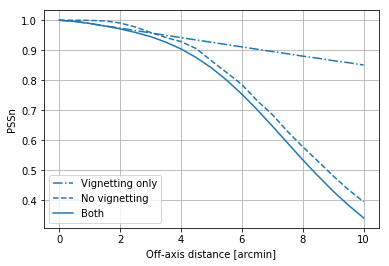

In [72]:
plt.plot(z,pssnv_z,'C0-.',label='Vignetting only')
plt.plot(z,pssnp_z,'C0--',label='No vignetting')
plt.plot(z,pssn_z,'C0',label='Both')
plt.grid()
plt.xlabel('Off-axis distance [arcmin]')
plt.ylabel('PSSn')
plt.legend(loc=0)

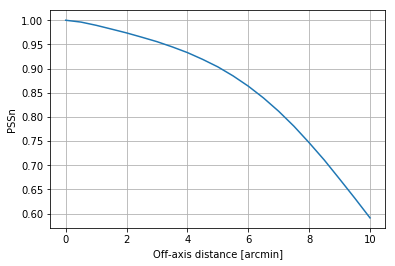

In [36]:
z = np.linspace(0,10,21)
pssn_z = [PSSn(x*ceo.constants.ARCMIN2RAD,0) for x in z]
plt.plot(z,pssn_z)
plt.grid()
plt.xlabel('Off-axis distance [arcmin]')
plt.ylabel('PSSn')

# Polishing errors

In [21]:
gmt = ceo.GMT_MX(M1_mirror_modes=u"polishing map")

!!polishing map!!


In [22]:
nPx = 480*3 + 1 

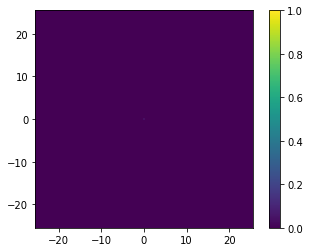

In [25]:
u = np.arange(2*nPx-1,dtype=np.float)*D/(nPx-1)
u = u-u[-1]/2
x,y = np.meshgrid(u,u)
rho = np.hypot(x,y)
C = atmOTF(rho,r0,L0)
plt.imshow(C,extent=[u[0],u[-1],u[0],u[-1]])
plt.colorbar()

In [26]:
imgr = ceo.Imaging(N_SIDE_LENSLET=1,N_PX_PUPIL=nPx-1,DFT_osf=4,N_PX_IMAGE=64)

In [44]:
src = ceo.Source('V',rays_box_sampling=nPx,rays_box_size=D,rays_origin=[0,0,25])
src>>(gmt,imgr)

OPTICAL PATH: ['GMT_MX', 'Imaging']


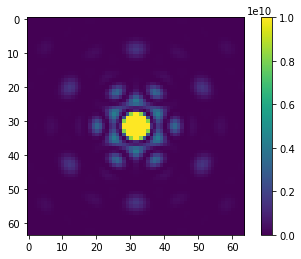

In [45]:
~gmt
~imgr
AW0 = OTF(0,0)
I0 = imgr.frame.host()
plt.imshow(I0)
plt.colorbar()
plt.clim([0,1e10])

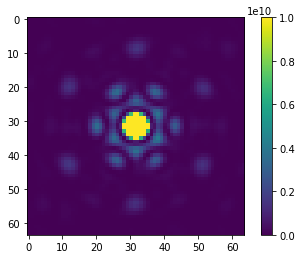

In [46]:
~gmt
gmt.M1.modes.a[:,:] = 1e-6
gmt.M1.modes.update()
~imgr
AW = OTF(0,0)
I = imgr.frame.host()
plt.imshow(I)
plt.colorbar()
plt.clim([0,1e10])

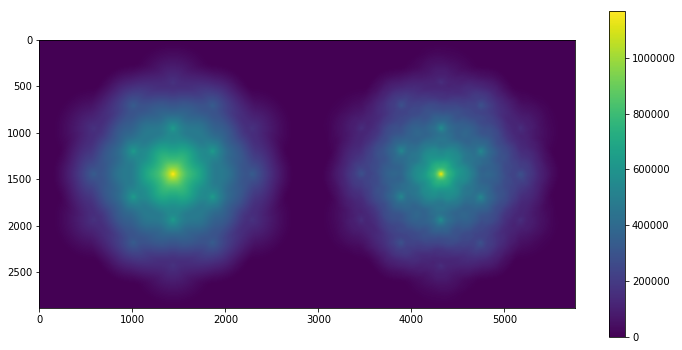

In [47]:
plt.figure(figsize=(12,6))
plt.imshow(np.abs(np.concatenate([AW0,AW],axis=1)))
plt.colorbar()

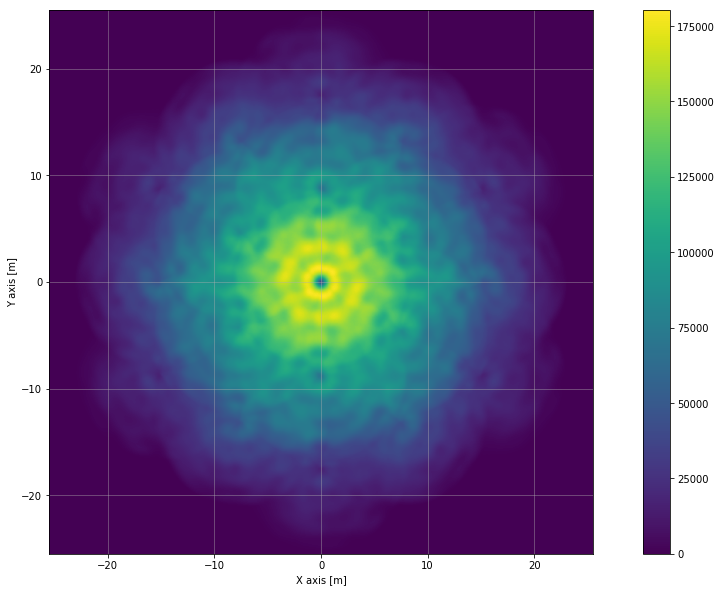

In [48]:
plt.figure(figsize=(18,10))
plt.imshow(np.abs(AW - AW0),extent=[u[0],u[-1],u[0],u[-1]])
plt.xlabel('X axis [m]')
plt.ylabel('Y axis [m]')
plt.colorbar()
plt.grid(alpha=0.5)

(-5.1000000000000005, 5.1000000000000005)

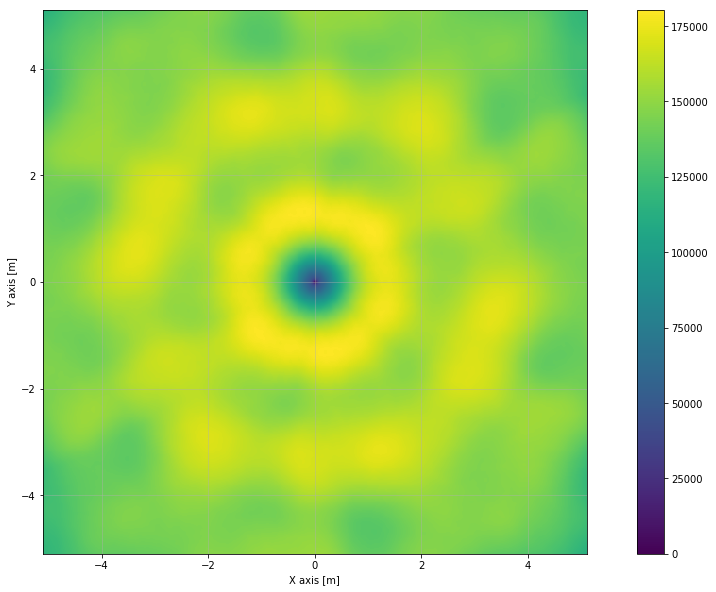

In [49]:
plt.figure(figsize=(18,10))
plt.imshow(np.abs(AW-AW0),extent=[u[0],u[-1],u[0],u[-1]])
plt.xlabel('X axis [m]')
plt.ylabel('Y axis [m]')
plt.colorbar()
plt.grid(alpha=0.5)
c = 0.2
plt.xlim([c*u[0],c*u[-1]])
plt.ylim([c*u[0],c*u[-1]])

In [50]:
def PSSn(zen,azi):
    AW = OTF(zen,azi)
    return np.sum(np.abs(AW*C)**2)/np.sum(np.abs(AW0*C)**2)

In [51]:
print PSSn(0,0)

0.948276176668


In [43]:
print np.sum(AW0), np.sum(OTF(0,0))

(1.36636e+12+1912.35j) (1.14712e+12+272.577j)


In [94]:
src.phaseRms(where='segments',units_exponent=-9)

array([[ 43.74840401,  43.74744833,  43.72451556,  43.74840401,
         43.74744833,  43.72451201,  45.214815  ]])

[ 43.93420383]


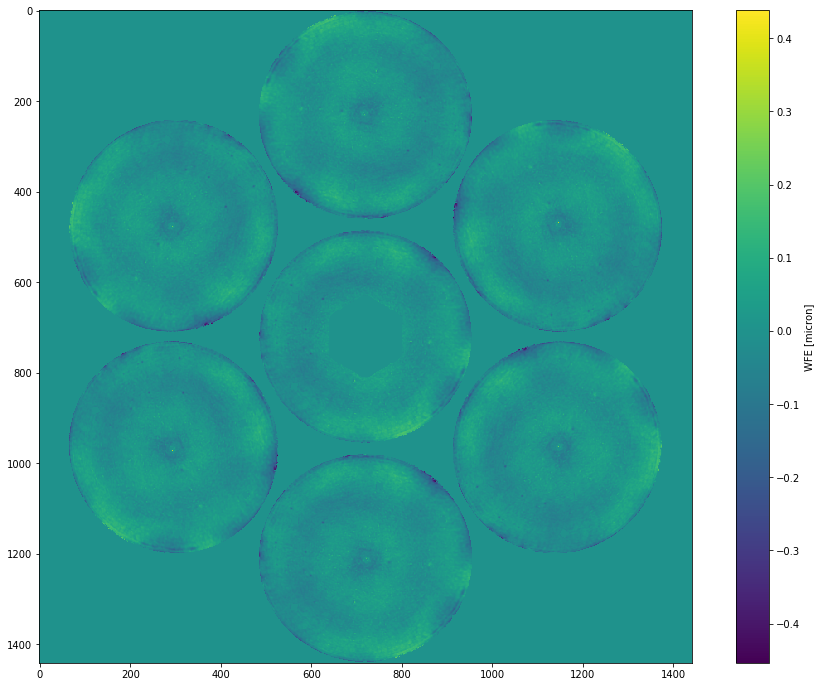

In [52]:
plt.figure(figsize=(16,12))
plt.imshow(src.phase.host(units='micron'))
plt.colorbar(label='WFE [micron]')
print src.wavefront.rms(-9)